# History Embedding

> Embed an environment into a more complex representation of state/observation-action histories

In [109]:
#| default_exp Environments/HistoryEmbedding

In [110]:
#| hide
# Imports for the nbdev development environment
# from nbdev.showdoc import *
from fastcore.test import *

In [111]:
#| hide
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Examples

In [112]:
#|eval: true notest
import numpy as np
import matplotlib.pyplot as plt
import copy

from pyCRLD.Environments.SocialDilemma import SocialDilemma
from pyCRLD.Environments.EcologicalPublicGood import EcologicalPublicGood

from pyCRLD.Agents.StrategyActorCritic import stratAC
from pyCRLD.Utils import FlowPlot as fp

np.random.seed(42)

In [113]:
from pyCRLD.Environments.HistoryEmbedding import HistoryEmbedded

In [114]:
ecopg = EcologicalPublicGood(N=2, f=1.2, c=5, m=-5, qc=0.2, qr=0.1)
ecopg.Sset

['g', 'p']

In [115]:
def generate_observation_tensor_for_only_state_information(state_set, observation_set):
    # Initialize the tensor
    tensor = np.zeros((2, len(state_set), len(observation_set)), dtype=int)
    
    # Generate the tensor
    for i in range(2):
        for j, state in enumerate(state_set):
            for k, observation in enumerate(observation_set):
                if observation in state:
                    tensor[i, j, k] = 1
    return tensor



### Memory-one Ecological Public Good

What is the effect of condition actions also on the past actions in the ecological public goods envrionment?

In [116]:
ecopg_with_history = HistoryEmbedded(ecopg, h=(1,1,1))
print("S-set", ecopg_with_history.Sset)
print("O-set", ecopg_with_history.Oset)
print("obs. tensor \n", ecopg_with_history.O)

ecopg_with_history_state_only_observation_tensor_modified = copy.deepcopy(ecopg_with_history)
ecopg_with_history_state_only_observation_tensor_modified.O = generate_observation_tensor_for_only_state_information(ecopg_with_history.Oset[0], ecopg.Sset)

print("obs. tensor modified \n", ecopg_with_history_state_only_observation_tensor_modified.O)






S-set ['c,c,g|', 'c,c,p|', 'c,d,g|', 'c,d,p|', 'd,c,g|', 'd,c,p|', 'd,d,g|', 'd,d,p|']
O-set [['c,c,g|', 'c,c,p|', 'c,d,g|', 'c,d,p|', 'd,c,g|', 'd,c,p|', 'd,d,g|', 'd,d,p|'], ['c,c,g|', 'c,c,p|', 'c,d,g|', 'c,d,p|', 'd,c,g|', 'd,c,p|', 'd,d,g|', 'd,d,p|']]
obs. tensor 
 [[[1. 0. 0. 0. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0. 0. 1. 0.]
  [0. 0. 0. 0. 0. 0. 0. 1.]]

 [[1. 0. 0. 0. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0. 0. 1. 0.]
  [0. 0. 0. 0. 0. 0. 0. 1.]]]
obs. tensor modified 
 [[[1 0]
  [0 1]
  [1 0]
  [0 1]
  [1 0]
  [0 1]
  [1 0]
  [0 1]]

 [[1 0]
  [0 1]
  [1 0]
  [0 1]
  [1 0]
  [0 1]
  [1 0]
  [0 1]]]


Visualizing the flow of learning in the prosperous state:

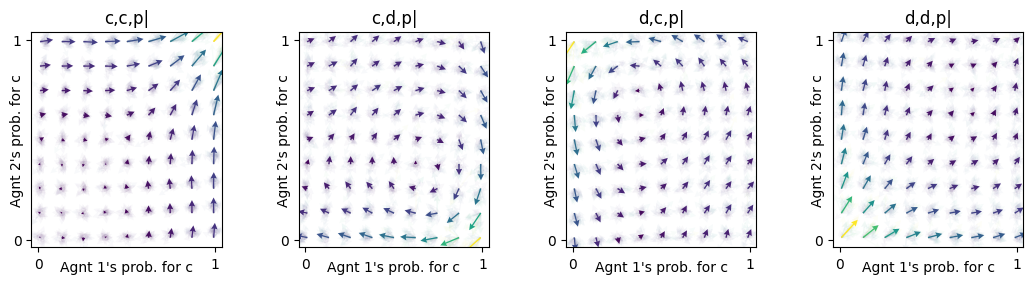

In [117]:
mae1 = stratAC(env=ecopg_with_history, learning_rates=0.1, discount_factors=0.9)
x = ([0], [1,3,5,7], [0])
y = ([1], [1,3,5,7], [0])
ax = fp.plot_strategy_flow(mae1, x, y, flowarrow_points=np.linspace(0.01 ,0.99, 9), NrRandom=32,
                           conds=np.array(mae1.env.Sset)[[1,3,5,7]])



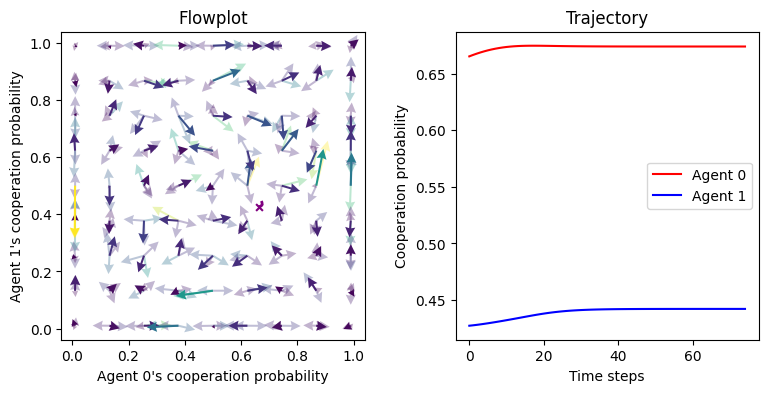

In [153]:
x = mae1.random_softmax_strategy()  # from a random inital strategy
xtraj, fixedpointreached = mae1.trajectory(x, Tmax=10000, tolerance=1e-5)


# PLOT
fig, axs = plt.subplots(1,2, figsize=(9,4))
plt.subplots_adjust(wspace=0.3)

# Plot in phase space
x = ([0], [0], [0])
y = ([1], [0], [0])


ax = fp.plot_strategy_flow(mae1, x, y, use_RPEarrows=False, flowarrow_points = np.linspace(0.01 ,0.99, 9), axes=[axs[0]])
fp.plot_trajectories([xtraj], x, y, cols=['purple'], axes=ax);
ax[0].set_xlabel("Agent 0's cooperation probability")
ax[0].set_ylabel("Agent 1's cooperation probability");
ax[0].set_title("Flowplot")

# Plot in trajectory
axs[1].plot(xtraj[:, 0, 0, 0], label="Agent 0", c='red')
axs[1].plot(xtraj[:, 1, 0, 0], label="Agent 1", c='blue')
axs[1].set_xlabel('Time steps')
axs[1].set_ylabel('Cooperation probability')
axs[1].legend()
axs[1].set_title("Trajectory");

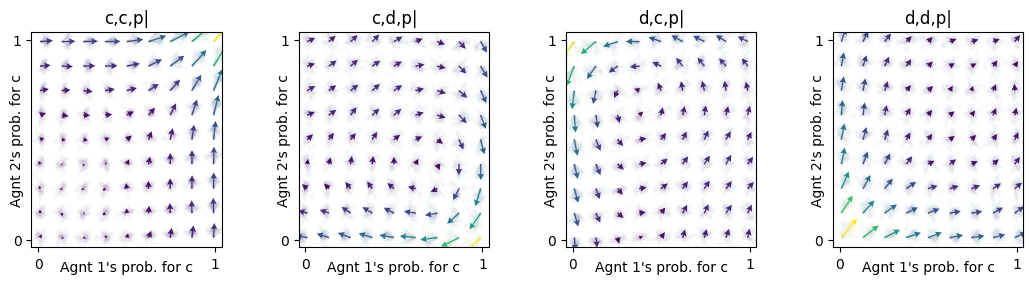

In [152]:
mae_modified_tensor = stratAC(env=ecopg_with_history_state_only_observation_tensor_modified, learning_rates=0.1, discount_factors=0.9)
x = ([0], [1,3,5,7], [0])
y = ([1], [1,3,5,7], [0])
ax = fp.plot_strategy_flow(mae_modified_tensor, x, y, flowarrow_points=np.linspace(0.01 ,0.99, 9), NrRandom=32,
                           conds=np.array(mae1.env.Sset)[[1,3,5,7]])

This flow has similarites to the flow of the memory-1 Prisoner's Dilemma above, yet with more tendency toward cooperation. This is expected, since the ecological public good without memory-1 has also more tendency towards cooperation.

In [119]:
#| hide
# import nbdev; nbdev.nbdev_export()

In [120]:
PyCRLD.Environments.HistoryEmbedding

NameError: name 'PyCRLD' is not defined

Partial